# PyBacktest - in vs. out-of-sample backtest

PyBacktest relies on the objective functions and optimisation methods contained in portopt

Often backtests are looked at based on in sample performance which can contain significant bias due to overfitting. There are many robust backtest methods to overcome such bias, one being using a walkforward technique. This performs the optimisation on a rolling in-sample interval and then tests the performance on a rolling out-of-sample interval.

The resulting time series is therefore based on out-of-sample numbers which are not seen during the optimisation.

---

## Import external libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data
%matplotlib inline

## Import pyport

In [2]:
from pyport.portopt import opt, objfunc
from pyport.portbt import PyBacktest
import pyport.portstats as stats

## Set parameters for data request

In [3]:
tickers = ['AGG', 'EBND', 'URTH', 'EEM']
data_source = 'yahoo'
start_date = '2014-03-31'
end_date = '2018-03-31'

## Request data, ensure sorted by ascending date, and normalise

In [4]:
panel_data = data.DataReader(tickers, data_source, start_date, end_date)
px_data = panel_data.loc['Adj Close'].dropna().sort_index(ascending=True)
px_data = px_data / px_data.iloc[0]

## Set optimisation parameters

In [5]:
"""
TEST CASE
Add constraints: Portfolio weights must sum to 100%, minimum ann. volatility target == 5.0%,
Add boundaries: Long only, no short positions.
"""

rf = 0.01
vol_trgt = 0.05

cons = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'eq', 'fun': lambda w: stats.vol(px_data, w) - vol_trgt}
]


bnds = [(0, 1) for x in px_data.columns]

## Run optimisation

In [6]:
opt_result = opt.port_optimisation(
    objfunc.max_dr, 
    px_data, rf=0.0, scaling_fact=252, conf_lvl=0.95, 
    constraints=cons, bounds=bnds
)

Optimization terminated successfully. Success==True after 7 iterations.
Total time: 0.13495397567749023 secs


## View optimised weights

In [7]:
opt_result['weights']

array([ 0.57193436,  0.15053699,  0.07760801,  0.19992064])

## Initialise backtest class

In [8]:
bt = PyBacktest(px_data, opt_period = 365, val_period = 90, rf=rf, scaling_fact=252)

## Generate historical optimisation weights and create out-of-sample results / time series

In [9]:
equal_weights = bt.bt_optimisation(objfunc.equal_weights, constraints=cons, bounds=bnds)
equal_weights_ts = bt.bt_timeseries(bt_type='out')

inv_volatility = bt.bt_optimisation(objfunc.inv_volatility, constraints=cons, bounds=bnds)
inv_volatility_ts = bt.bt_timeseries(bt_type='out')

inv_variance = bt.bt_optimisation(objfunc.inv_variance, constraints=cons, bounds=bnds)
inv_variance_ts = bt.bt_timeseries(bt_type='out')

max_er = bt.bt_optimisation(objfunc.max_er, constraints=cons, bounds=bnds)
max_er_ts = bt.bt_timeseries(bt_type='out')

min_vol = bt.bt_optimisation(objfunc.min_vol, constraints=cons, bounds=bnds)
min_vol_ts = bt.bt_timeseries(bt_type='out')

max_sr = bt.bt_optimisation(objfunc.max_sr, constraints=cons, bounds=bnds)
max_sr_ts = bt.bt_timeseries(bt_type='out')

risk_parity = bt.bt_optimisation(objfunc.risk_parity, constraints=cons, bounds=bnds)
risk_parity_ts = bt.bt_timeseries(bt_type='out')

max_dr = bt.bt_optimisation(objfunc.max_dr, constraints=cons, bounds=bnds)
max_dr_ts = bt.bt_timeseries(bt_type='out')

min_mdd = bt.bt_optimisation(objfunc.min_mdd, constraints=cons, bounds=bnds)
min_mdd_ts = bt.bt_timeseries(bt_type='out')

max_skew = bt.bt_optimisation(objfunc.max_skew, constraints=cons, bounds=bnds)
max_skew_ts = bt.bt_timeseries(bt_type='out')

min_hVaR = bt.bt_optimisation(objfunc.min_hVaR, constraints=cons, bounds=bnds)
min_hVaR_ts = bt.bt_timeseries(bt_type='out')

min_hcVaR = bt.bt_optimisation(objfunc.min_hcVaR, constraints=cons, bounds=bnds)
min_hcVaR_ts = bt.bt_timeseries(bt_type='out')

Algorithm: equal_weights
Total time: 0.012 secs

Type: out-of-sample data

Algorithm: inv_volatility
Total time: 0.0157 secs

Type: out-of-sample data

Algorithm: inv_variance
Total time: 0.0063 secs

Type: out-of-sample data

Algorithm: max_er
Total time: 0.9396 secs

Type: out-of-sample data

Algorithm: min_vol
Total time: 1.4369 secs

Type: out-of-sample data

Algorithm: max_sr
Total time: 1.1277 secs

Type: out-of-sample data

Algorithm: risk_parity
Total time: 1.0902 secs

Type: out-of-sample data

Algorithm: max_dr
Total time: 1.6645 secs

Type: out-of-sample data

Algorithm: min_mdd
Total time: 1.0289 secs

Type: out-of-sample data

Algorithm: max_skew
Total time: 0.9536 secs

Type: out-of-sample data

Algorithm: min_hVaR
Total time: 2.081 secs

Type: out-of-sample data

Algorithm: min_hcVaR
Total time: 2.2081 secs

Type: out-of-sample data



## Create df of individual results

In [10]:
comp_df = pd.concat(
    [
        equal_weights_ts.MV,
        inv_volatility_ts.MV,
        inv_variance_ts.MV,
        max_er_ts.MV, 
        min_vol_ts.MV, 
        max_sr_ts.MV, 
        risk_parity_ts.MV, 
        max_dr_ts.MV, 
        min_mdd_ts.MV, 
        max_skew_ts.MV,
        min_hVaR_ts.MV,
        min_hcVaR_ts.MV
    ], 
    axis=1
)

comp_df.columns = [
    'equal_weights',
    'inv_volatility',
    'inv_variance',
    'max_er', 
    'min_vol', 
    'max_sr', 
    'risk_parity', 
    'max_dr', 
    'min_mdd',
    'max_skew',
    'min_hVaR',
    'min_cVaR'
]

## Plot and compare out-of-sample optimisation results

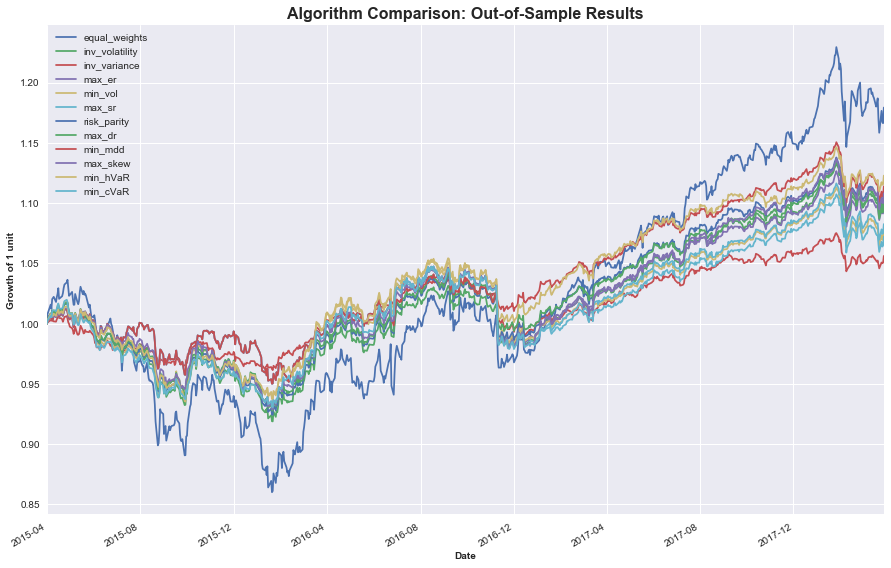

In [11]:
comp_df.plot(figsize=(15,10))
plt.title('Algorithm Comparison: Out-of-Sample Results', fontweight='bold', fontsize=16)
plt.ylabel('Growth of 1 unit', fontweight='bold', fontsize=10)
plt.xlabel('Date', fontweight='bold', fontsize=10)
plt.legend(loc='best');

## View summary of out-of-sample statistics

In [12]:
res = stats.stats_summary(comp_df, rf=rf)
res

,equal_weights,inv_volatility,inv_variance,max_er,min_vol,max_sr,risk_parity,max_dr,min_mdd,max_skew,min_hVaR,min_cVaR
cumu_return,0.179222,0.104141,0.056094,0.099196,0.077625,0.082526,0.109006,0.100257,0.113859,0.108093,0.122749,0.072018
ann_return,0.056596,0.033636,0.018393,0.032088,0.025280,0.026834,0.035155,0.032421,0.036665,0.034870,0.039421,0.023495
volatility,0.094358,0.051867,0.031649,0.053529,0.051236,0.053637,0.051204,0.050699,0.049887,0.052533,0.049749,0.050949
sharpe_ratio,0.493815,0.455715,0.265187,0.412638,0.298223,0.313860,0.491271,0.442233,0.534520,0.473426,0.591389,0.264877
max_drawdown,-0.170057,-0.097174,-0.044900,-0.062735,-0.080538,-0.064563,-0.091024,-0.087887,-0.060937,-0.082968,-0.077758,-0.087678
skew,-0.578871,-0.501733,-0.491538,-1.263819,-1.489938,-1.438333,-0.575853,-0.523782,-0.689529,-1.339654,-0.668298,-1.504419
kurtosis,2.858959,2.179820,1.905112,9.051311,12.194646,10.560971,2.884698,2.506914,3.257111,10.715982,4.123414,12.446651


## Approaches sorted by sharpe ratio

The out-of-sample max_sr results are far from the top. This suggests that max_er may perform poorly if implemented.

In [13]:
res.loc['sharpe_ratio'].sort_values(ascending=False)

min_hVaR          0.591389
min_mdd           0.534520
equal_weights     0.493815
risk_parity       0.491271
max_skew          0.473426
inv_volatility    0.455715
max_dr            0.442233
max_er            0.412638
max_sr            0.313860
min_vol           0.298223
inv_variance      0.265187
min_cVaR          0.264877
Name: sharpe_ratio, dtype: float64

## In-Sample Optimisation

In [14]:
algo_in = bt.bt_optimisation(objfunc.risk_parity, constraints=cons, bounds=bnds)
algo_in_ts = bt.bt_timeseries(bt_type='in', start_date='out')

Algorithm: risk_parity
Total time: 1.1035 secs

Type: in-sample data



## In-Sample vs. Out-of-Sample Comparison

In [15]:
in_samp_algo = algo_in_ts.MV
out_samp_algo = risk_parity_ts.MV

algo_comp_df = pd.concat(
    [
        in_samp_algo,
        out_samp_algo
    ], 
    axis=1
)

algo_comp_df.columns = [
    'in_samp_algo',
    'out_samp_algo'
]

## Plot and compare in and out-of-sample optimisation results

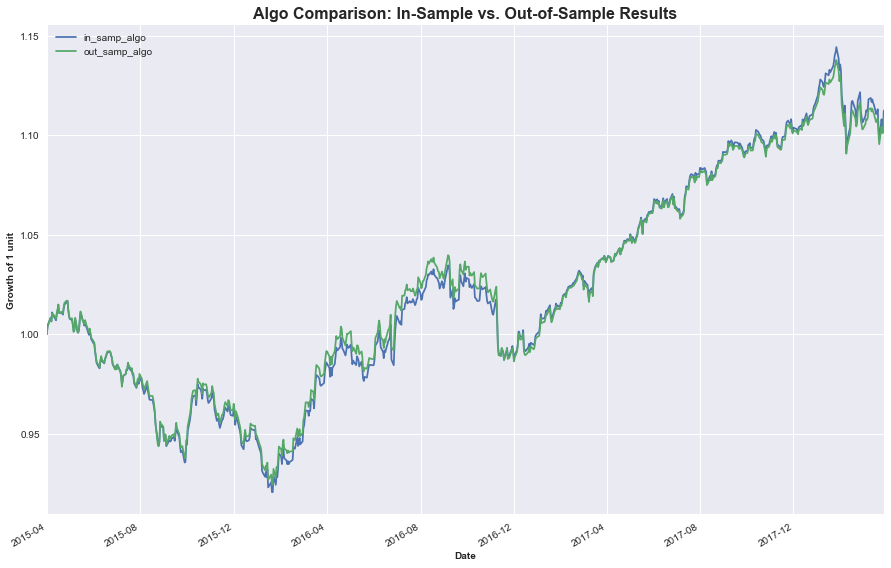

In [16]:
algo_comp_df.plot(figsize=(15,10))
plt.title('Algo Comparison: In-Sample vs. Out-of-Sample Results', fontweight='bold', fontsize=16)
plt.ylabel('Growth of 1 unit', fontweight='bold', fontsize=10)
plt.xlabel('Date', fontweight='bold', fontsize=10)
plt.legend(loc='best');

## View summary of in and out-of-sample statistics

In [17]:
algo_res = stats.stats_summary(algo_comp_df, rf=rf)
algo_res

,in_samp_algo,out_samp_algo
cumu_return,0.112414,0.109006
ann_return,0.036216,0.035155
volatility,0.051153,0.051204
sharpe_ratio,0.512506,0.491271
max_drawdown,-0.094633,-0.091024
skew,-0.506419,-0.575853
kurtosis,2.476521,2.884698
